In [1]:
!pip install numpyro

In [2]:
import pandas as pd
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
import matplotlib.pyplot as plt
from numpyro.infer import Predictive

# Question 1

In [3]:
df = pd.read_csv(
    'https://github.com/pymc-devs/resources/raw/'
    'master/Rethinking_2/End_of_chapter_problems/data/Howell1.csv',
    delimiter=';'
)
adult_df = df[df.age >= 18]

In [4]:
xbar = adult_df.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

#optimiser = numpyro.optim.Adam(1e-5)
optimiser = numpyro.optim.Adam(1) # Be careful! the first argument is step size (not epsilon!)
guide = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    guide,
    optimiser,
    loss=Trace_ELBO(),
    weight=adult_df.weight.values,
    height=adult_df.height.values
)
result = svi.run(random.PRNGKey(2), 2000) # Needs to run for 2000 to avoid singular hessian

100%|██████████| 2000/2000 [00:01<00:00, 1569.65it/s, init loss: 25280.3164, avg. loss [1901-2000]: 1079.3341]


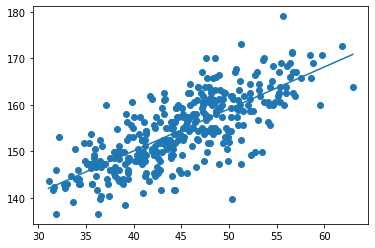

In [5]:
plt.scatter(adult_df.weight.values, adult_df.height.values)
x = jnp.linspace(adult_df.weight.min(), adult_df.weight.max(), 100)
a_map, b_map, _ = result.params['auto_loc']
plt.plot(x, a_map + b_map * (x - adult_df.weight.mean()))
plt.show()

In [6]:
pred_w = [45, 40, 65, 31]
samples = guide.sample_posterior(random.PRNGKey(1), result.params, (1000,))
mus = [samples["a"] + samples["b"] * (w - xbar) for w in pred_w]
pd.DataFrame(
    data = [
        (pred_w[i], mu.mean()) + tuple(jnp.percentile(mu, q=(5.5, 94.5)))
        for i, mu in enumerate(mus)
    ],
    columns = ['weight', 'expected height', 'lower Interval', 'upper interval']
)

,weight,expected height,lower Interval,upper interval
0,45,154.62804,154.181458,155.051865
1,40,150.11339,149.532455,150.657547
2,65,172.68654,171.300369,174.170151
3,31,141.98708,140.936783,143.011276


# Question 2

In [7]:
logweight = jnp.log(df.weight.values)
logxbar = logweight.mean()

def log_model(lw, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (lw - logxbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [8]:
log_guide = AutoLaplaceApproximation(log_model)
svi = SVI(
    log_model,
    log_guide,
    numpyro.optim.Adam(1),
    loss=Trace_ELBO(),
    lw=logweight,
    height=df.height.values
)
log_result = svi.run(random.PRNGKey(2), 5000)

100%|██████████| 5000/5000 [00:01<00:00, 2964.78it/s, init loss: 32668.0059, avg. loss [4751-5000]: 2498.6316]


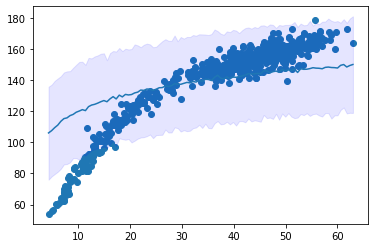

In [9]:
fig, ax = plt.subplots()
ax.scatter(df.weight.values, df.height.values)
x = jnp.linspace(df.weight.min(), df.weight.max(), 100)
samples = log_guide.sample_posterior(random.PRNGKey(1), log_result.params, (1000,))
predictions = Predictive(log_model, samples)(random.PRNGKey(1), lw=jnp.log(x))
p_means = jnp.mean(predictions['height'], axis=0)
p_intervals = jnp.percentile(predictions['height'], q=(5.5, 94.5), axis=0)
ax.plot(x, p_means)
ax.fill_between(x, p_intervals[0], p_intervals[1], color='b', alpha=.1)

# Question 3

In [10]:
ws = jnp.array((df.weight - df.weight.mean()) / df.weight.std())
ws2 = ws ** 2


def quad_model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [11]:
prior_samples = Predictive(
    quad_model,
    {}, # dirty dirty
    num_samples=100)(
    random.PRNGKey(1),
    weight_s = ws,
    weight_s2=ws2
)
print_summary({
    k : v
    for k, v in prior_samples.items()
    if not k in {'mu', 'height'}
}, group_by_chain=False) # group_by_chain=False stops errors


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a    178.96     19.58    179.28    148.41    215.95    100.25      0.99
        b1      1.52      1.65      1.01      0.04      4.04    107.48      1.01
        b2     -0.15      1.02     -0.16     -1.97      1.41    107.07      0.99
     sigma     25.27     14.80     24.01      2.64     47.73    106.70      0.99



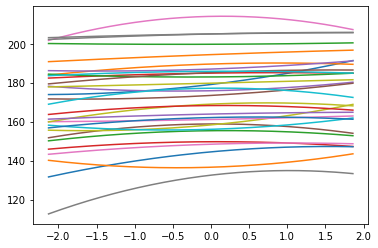

In [12]:
n_parabolas = 30
fig, ax = plt.subplots()
ws_order = jnp.argsort(ws)
for i in range(n_parabolas):
    ax.plot(ws[ws_order], prior_samples['mu'][i, ws_order])

Let's make a quadratic model with a prior which bends upwards

In [13]:
def quad_model_upwards(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(2, 1))
    b2 = numpyro.sample("b2", dist.LogNormal(1, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

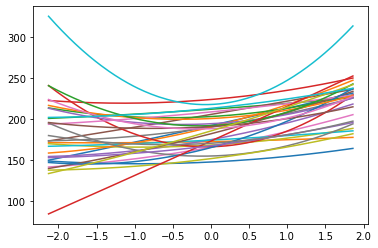

In [14]:
prior_samples_upwards = Predictive(
    quad_model_upwards,
    {}, # dirty dirty
    num_samples=n_parabolas)(
    random.PRNGKey(1),
    weight_s = ws,
    weight_s2=ws2
)
fig, ax = plt.subplots()
for i in range(n_parabolas):
    ax.plot(ws[ws_order], prior_samples_upwards['mu'][i, ws_order])